In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from collections import Counter

In [4]:
# Configurar estilo de seaborn
sns.set_style('darkgrid')

In [5]:
def load_boston_housing():
    """Carga el dataset de Boston Housing desde URL"""
    url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"

    try:
        dataset = pd.read_csv(url)
        print("✅ Dataset cargado exitosamente desde URL")
        return dataset
    except Exception as e:
        print(f"❌ Error cargando dataset: {e}")
        return None

df = load_boston_housing()


✅ Dataset cargado exitosamente desde URL


In [7]:

# Función de exploración inicial
def explore_dataset(df):
    """Exploración inicial del dataset"""
    print("="*50)
    print("📊 EXPLORACIÓN INICIAL DEL DATASET")
    print("="*50)

    # Información básica
    print(f"📏 Dimensiones: {df.shape}")
    print(f"📋 Columnas: {list(df.columns)}")
    print(f"🔍 Tipos de datos:")
    print(df.dtypes)
    print()

    # Estadísticas descriptivas
    print("📈 ESTADÍSTICAS DESCRIPTIVAS:")
    print(df.describe())
    print()

    # Valores faltantes
    print("❓ VALORES FALTANTES:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "✅ No hay valores faltantes")
    print()

    # Variable objetivo
    target_col = 'medv' if 'medv' in df.columns else df.columns[-1]
    print(f"🎯 Variable objetivo: '{target_col}'")
    print(f"   Rango: {df[target_col].min():.2f} - {df[target_col].max():.2f}")
    print(f"   Media: {df[target_col].mean():.2f}")
    print(f"   Mediana: {df[target_col].median():.2f}")
    print()

    return target_col
target_col = explore_dataset(df)


📊 EXPLORACIÓN INICIAL DEL DATASET
📏 Dimensiones: (506, 14)
📋 Columnas: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']
🔍 Tipos de datos:
crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
b          float64
lstat      float64
medv       float64
dtype: object

📈 ESTADÍSTICAS DESCRIPTIVAS:
             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      

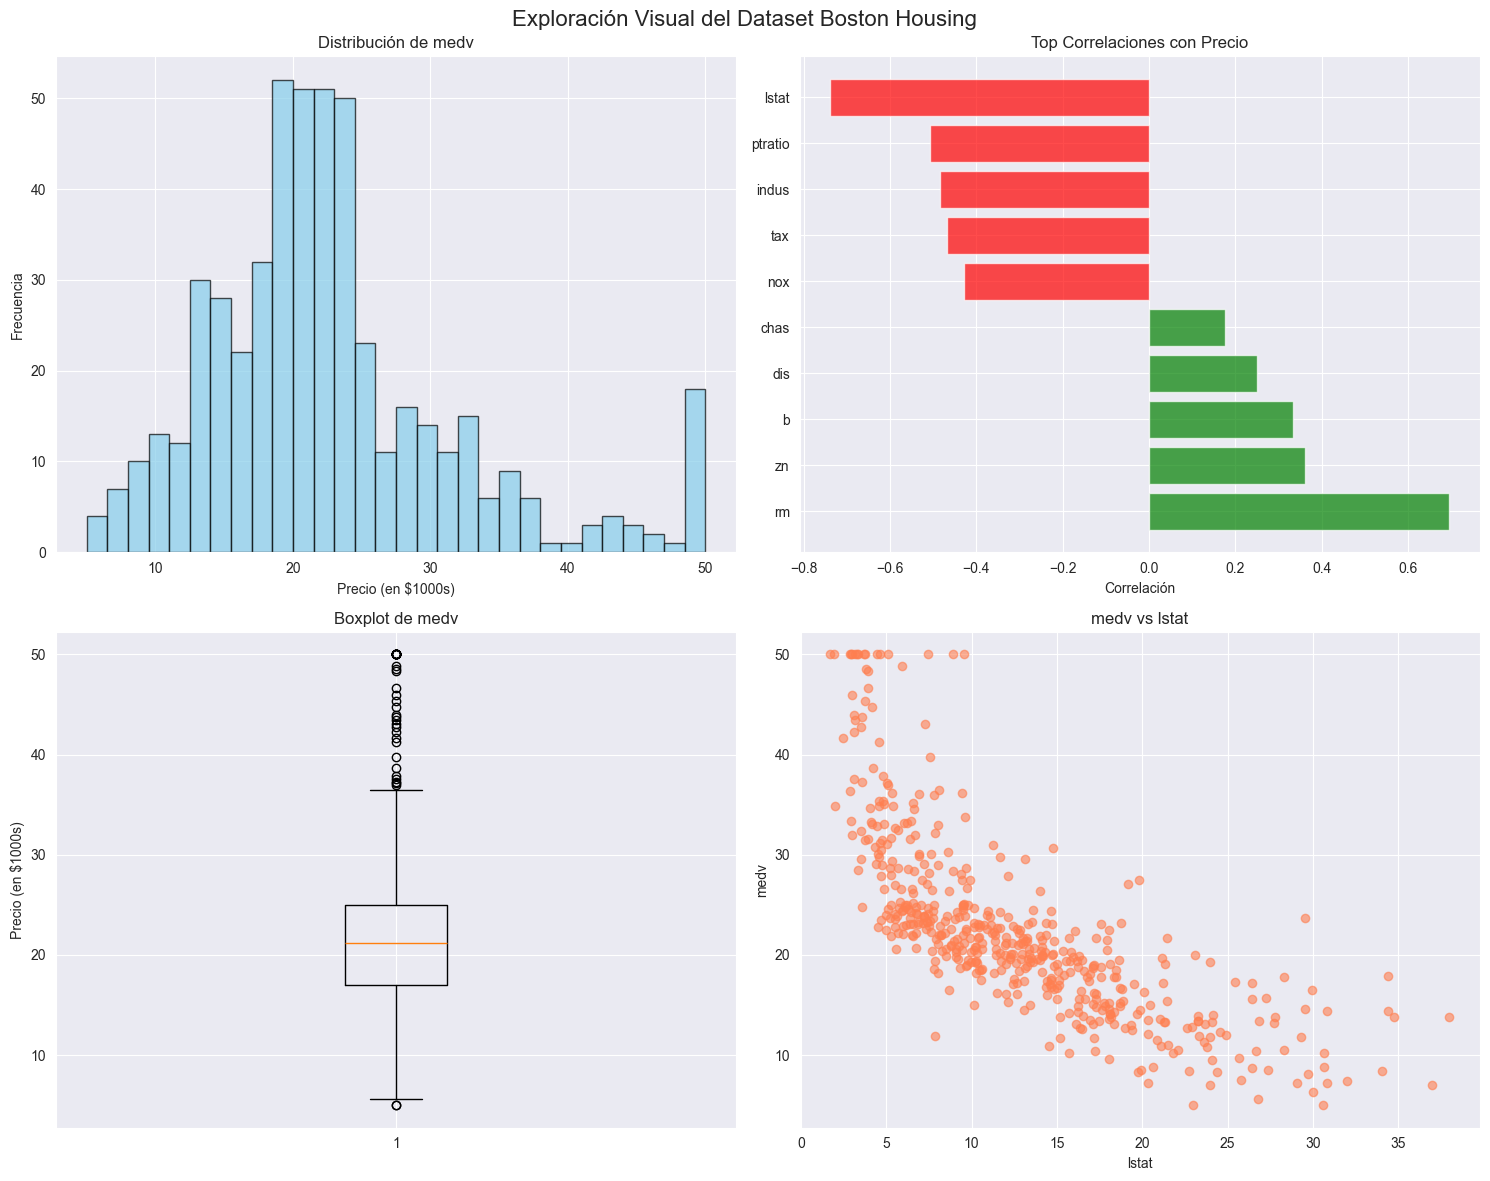

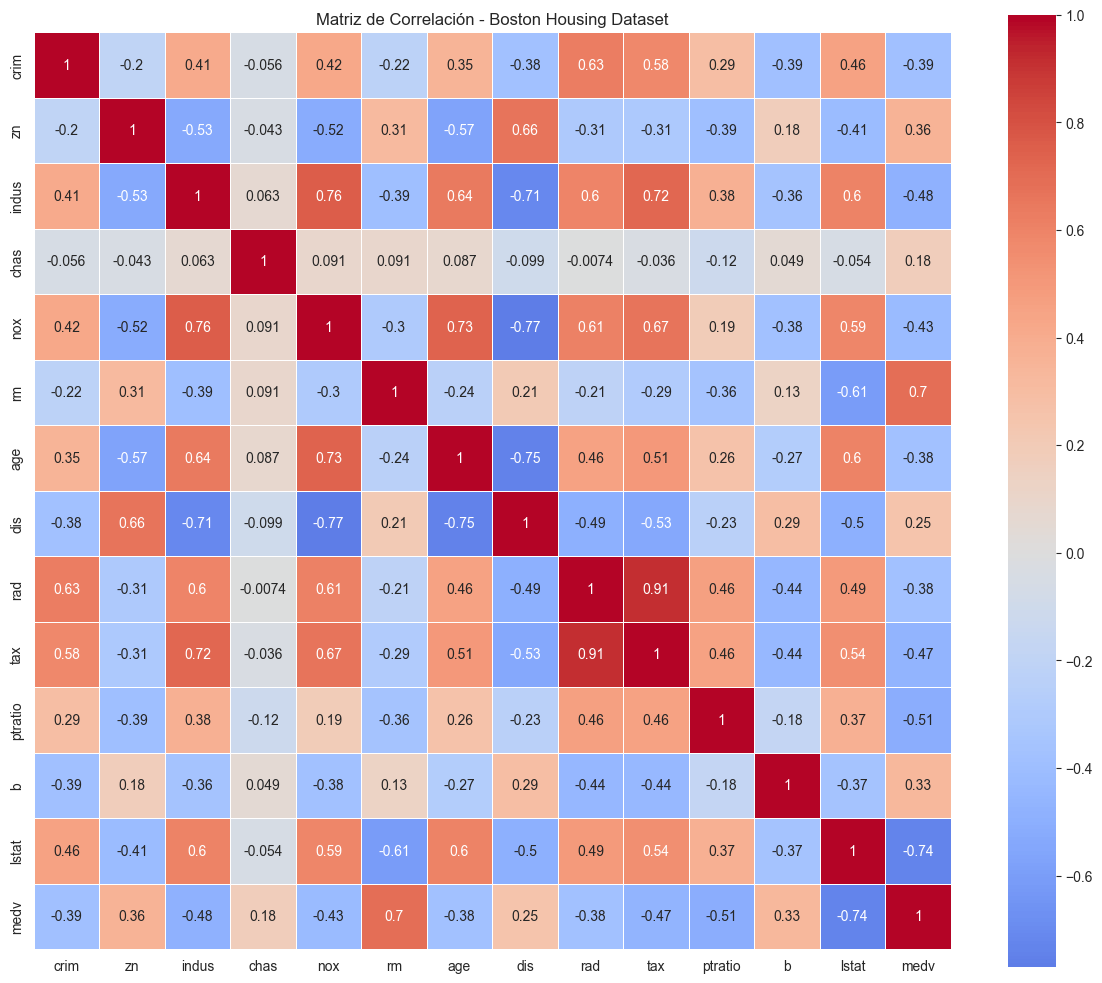

In [12]:

def visualize_dataset(df, target_col):
    """Crear visualizaciones básicas"""

    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Exploración Visual del Dataset Boston Housing', fontsize=16)

    # 1. Distribución de la variable objetivo
    axes[0, 0].hist(df[target_col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title(f'Distribución de {target_col}')
    axes[0, 0].set_xlabel('Precio (en $1000s)')
    axes[0, 0].set_ylabel('Frecuencia')

    # 2. Correlación con variable objetivo
    correlations = df.corr()[target_col].sort_values(ascending=False)
    correlations = correlations.drop(target_col)  # Remover autocorrelación

    # Top 10 correlaciones
    top_corr = pd.concat([correlations.head(5), correlations.tail(5)])
    colors = ['green' if x > 0 else 'red' for x in top_corr.values]

    axes[0, 1].barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_corr)))
    axes[0, 1].set_yticklabels(top_corr.index)
    axes[0, 1].set_title('Top Correlaciones con Precio')
    axes[0, 1].set_xlabel('Correlación')

    # 3. Boxplot de variable objetivo
    axes[1, 0].boxplot(df[target_col])
    axes[1, 0].set_title(f'Boxplot de {target_col}')
    axes[1, 0].set_ylabel('Precio (en $1000s)')

    # 4. Scatter plot con la variable más correlacionada
    best_feature = correlations.abs().idxmax()
    axes[1, 1].scatter(df[best_feature], df[target_col], alpha=0.6, color='coral')
    axes[1, 1].set_title(f'{target_col} vs {best_feature}')
    axes[1, 1].set_xlabel(best_feature)
    axes[1, 1].set_ylabel(target_col)

    plt.tight_layout()
    plt.show()

    # Matriz de correlación
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Matriz de Correlación - Boston Housing Dataset')
    plt.tight_layout()
    plt.show()

    return correlations
correlations = visualize_dataset(df, target_col)



In [13]:

def baseline_model(df, target_col):
    """Crear modelo baseline simple"""
    print("="*50)
    print("🤖 MODELO BASELINE")
    print("="*50)

    # Preparar datos
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"📊 Datos de entrenamiento: {X_train.shape}")
    print(f"📊 Datos de prueba: {X_test.shape}")

    # Modelo simple
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print(f"\n📈 MÉTRICAS DEL MODELO:")
    print(f"   R² Entrenamiento: {train_r2:.4f}")
    print(f"   R² Prueba: {test_r2:.4f}")
    print(f"   MAE Entrenamiento: {train_mae:.4f}")
    print(f"   MAE Prueba: {test_mae:.4f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"   R² Cross-Validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return model, X_test, y_test, y_pred_test

model, X_test, y_test, y_pred_test = baseline_model(df, target_col)



🤖 MODELO BASELINE
📊 Datos de entrenamiento: (404, 13)
📊 Datos de prueba: (102, 13)

📈 MÉTRICAS DEL MODELO:
   R² Entrenamiento: 0.7509
   R² Prueba: 0.6688
   MAE Entrenamiento: 3.3148
   MAE Prueba: 3.1891
   R² Cross-Validation: 0.3533 (+/- 0.7531)
